# **Final Project: Natual Language to Shell Command (NL2Sh)**
- This system will translate the user's natural language description of the task to shell command. With three agents: clarifier, composer, and inspector, the system will explain the user's task, compose a command, and inspect the command. If there is a mistake, a guide will be proposed by the inspector.
- This is the demo notebook of our project, which include the most steps from data preparation, agent pipeline initialization, inference, and E2E evaluation.
>P.S: Fine-tune steps will be finished on OpenAI Platform, so the code of this part is not included.

## Install Environment

In [1]:
# Create virtual environment and install all packages needed
!python -m venv .venv
!source .venv/bin.activate
!pip install .

/bin/bash: line 1: .venv/bin.activate: No such file or directory
Processing /home/cybercricetus/Desktop/myThingz/schoolThings/grad_1/dl/NL2Sh
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for NL2Sh: filename=nl2sh-0.1.0-py3-none-any.whl size=109310 sha256=f0774eef44f1fc1e8aadd20ab2cd72310a6740cc33d3d2a0cd2247b2dad699f7
  Stored in directory: /tmp/pip-ephem-wheel-cache-bx3h09jl/wheels/50/07/6c/925f157105bacd6271a21f211be14dde8dccf2dcf91dabf554
Successfully built NL2Sh
  Attempting uninstall: NL2Sh
    Found existing installation: NL2Sh 0.1.0
    Uninstalling NL2Sh-0.1.0:
      Successfully uninstalled NL2Sh-0.1.0

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


### **Remember to select the kernel from .venv !!!**

## Prepare datasets
- We use the `westenfelder/NL2SH-ALFA` dataset with 40k train samples and a test sets with 300 data.
- This dataset contains natural languages description of tasks and the corresponding shell commands.
- Because of the limitation in time and computes, we only use 1000 samples in the train set and 50 samples as our validation set.
- More information can be seen [here](https://huggingface.co/datasets/westenfelder/NL2SH-ALFA).

In [2]:
# import necessary functions
from nl2sh.data.dataloader import generate_eval_data, generate_finetune_data, generate_validation_data

### Create a 1k-data train set

In [3]:
generate_finetune_data('data/train_set.jsonl') # make sure it's a jsonl

Loading dataset...
Starting ShellCheck scan... Target: 1000 high-quality records.
Scanned: 1200 | Kept: 979 | Pass Rate: 81.6%

Done!
Successfully generated file: data/train_set.jsonl
------------------------------
Final Filter Stats:
- Total Scanned: 1225
- Kept (Safe):   1000
- Rejected:      225
- Final Pass Rate: 81.6%
------------------------------


- Then you will see a `train_set.jsonl` in the `data` dir.

### Create Validation set

In [4]:
generate_validation_data("data/val_set.jsonl")

Loading Test dataset...
Test dataset loaded. Total records: 300
Pool Stats: Diff_0: 100, Diff_1: 100, Diff_2: 100

Successfully generated file: data/val_set.jsonl
------------------------------
Validation Set Composition:
- Difficulty 0: 17 records
- Difficulty 1: 17 records
- Difficulty 2: 16 records
------------------------------


Now we have two jsonl's in the `data` folder. We used these two dataset in the fine-tuning of our model. Configuration:
```text
Model = GPT-4o-mini,
Epoch = 1,
Batch size = 1,
LR multiplier = 1.8,
Seed = 114514
```

### Next, we create our evaluation set with 50 randomly selected data from the train set.
- Here the difficulties are evenly distributed.

In [5]:
generate_eval_data("data/eval_set.jsonl")

Loading Test dataset...
Test dataset loaded. Total records: 300
Pool Stats: Diff_0: 100, Diff_1: 100, Diff_2: 100

Successfully generated file: data/eval_set.jsonl
------------------------------
Eval Set Composition:
- Difficulty 0: 16 records
- Difficulty 1: 17 records
- Difficulty 2: 17 records
------------------------------


## Next, let's try one example with this example

In [6]:
from nl2sh.main import Inference, load_evaluation_nl

### Create an instance with the default configurations

In [7]:
system_default = Inference()

Current model settings: 
Composer = gpt-4o-mini 
Clarifier = gpt-4o-mini 
Inspector = gpt-5.1


In [8]:
# because this is a simple task and to save time, we set the max_recompose to 1.
task = 'Show all files and folders in the current directory'
resp = system_default.run_single(task = task, max_recompose= 1)
print(f"To handle task {task}, you need to run {resp}.")

Current Task: Show all files and folders in the current directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


 NL2SH Evaluation Report
User Input        : Show all files and folders in the current directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 1
Final Command     : ls -a
To handle task Show all files and folders in the current directory, you need to run ('ls -a', 0).


### Seems interesting... Now let's start our evaluation! Let's see how our default configuration performs!

#### Load the test_set

In [9]:
test_sets = load_evaluation_nl(
    path = 'data/eval_set.jsonl',
)

#### Let's generate the answers for the test_set

In [10]:
ans_default = system_default.gen_eval_commands(test_sets, max_recompose= 2, ofile = 'eval_results/default_ans.txt') # let the max_recompose be 2 to make sure it has 3 times to correct the mistakes

Evaluating tasks:   0%|          | 0/50 [00:00<?, ?task/s]

Current Task: display the first 5 lines of the setup_nl2b_fs_1.sh file 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   2%|▏         | 1/50 [00:05<04:38,  5.68s/task]



 NL2SH Evaluation Report
User Input        : display the first 5 lines of the setup_nl2b_fs_1.sh file
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : head -n 5 setup_nl2b_fs_1.sh
Current Task: Count the number of regular files in directory tree ${DIRECTORY} that contain a vowel in their names 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   4%|▍         | 2/50 [00:10<04:21,  5.44s/task]



 NL2SH Evaluation Report
User Input        : Count the number of regular files in directory tree ${DIRECTORY} that contain a vowel in their names
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find "${DIRECTORY}" -type f -name '*[aeiou]*' | wc -l
Current Task: Dump "/system/text1.txt" as ASCII characters 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   6%|▌         | 3/50 [00:16<04:21,  5.57s/task]



 NL2SH Evaluation Report
User Input        : Dump "/system/text1.txt" as ASCII characters
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cat /system/text1.txt | iconv -f UTF-8 -t ASCII//TRANSLIT
Current Task: Print the last 10 lines of the file /testbed/dir3/subdir1/subsubdir1/textfile3.txt 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   8%|▊         | 4/50 [00:22<04:15,  5.56s/task]



 NL2SH Evaluation Report
User Input        : Print the last 10 lines of the file /testbed/dir3/subdir1/subsubdir1/textfile3.txt
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : tail -n 10 /testbed/dir3/subdir1/subsubdir1/textfile3.txt
Current Task: Get the total size of all files in testbed/ and save it to total_size.txt 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  10%|█         | 5/50 [00:32<05:19,  7.10s/task]



 NL2SH Evaluation Report
User Input        : Get the total size of all files in testbed/ and save it to total_size.txt
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find testbed/ -type f -exec du -b {} + | awk '{total += $1} END {print total}' > total_size.txt
Current Task: Find files in the /workspace directory and sub-directories, that changed over an hour ago. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  12%|█▏        | 6/50 [00:37<04:45,  6.50s/task]



 NL2SH Evaluation Report
User Input        : Find files in the /workspace directory and sub-directories, that changed over an hour ago.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -type f -mmin +60
Current Task: display the routing table 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  14%|█▍        | 7/50 [00:42<04:24,  6.15s/task]



 NL2SH Evaluation Report
User Input        : display the routing table
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : route -n
Current Task: Create an empty file "abc.txt" in each directory named "dir1" under testbed directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  16%|█▌        | 8/50 [00:48<04:07,  5.88s/task]



 NL2SH Evaluation Report
User Input        : Create an empty file "abc.txt" in each directory named "dir1" under testbed directory.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find testbed -type d -name "dir1" -exec touch {}/abc.txt \;
Current Task: Create a symbolc link in the /workspace/dir1 to root folder 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  18%|█▊        | 9/50 [00:54<04:08,  6.06s/task]



 NL2SH Evaluation Report
User Input        : Create a symbolc link in the /workspace/dir1 to root folder
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ln -s / /workspace/dir1/link_to_root
Current Task: print running processes in a tree format 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  20%|██        | 10/50 [01:00<03:55,  5.90s/task]



 NL2SH Evaluation Report
User Input        : print running processes in a tree format
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : pstree
Current Task: print every other line of setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  22%|██▏       | 11/50 [01:05<03:45,  5.78s/task]



 NL2SH Evaluation Report
User Input        : print every other line of setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sed -n 'n;p' setup_nl2b_fs_1.sh
Current Task: Calculate the md5 sum of all files in directory tree "/workspace" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  24%|██▍       | 12/50 [01:10<03:34,  5.64s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of all files in directory tree "/workspace"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -type f -exec md5sum {} +
Current Task: Calculate the md5 sum of all files in the /workspace directory with the filename printed first 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next

Evaluating tasks:  26%|██▌       | 13/50 [01:25<05:09,  8.37s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of all files in the /workspace directory with the filename printed first
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /workspace -type f -exec md5sum {} + | awk '{print $2 ": " $1}'
Current Task: search for the word "hello" in all the regular/normal files in the  /workspace folder and display the matched file name 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  28%|██▊       | 14/50 [01:32<04:40,  7.79s/task]



 NL2SH Evaluation Report
User Input        : search for the word "hello" in all the regular/normal files in the  /workspace folder and display the matched file name
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : grep -rl "hello" /workspace/*
Current Task: Print numbers 1 through 10 separated by ":" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  30%|███       | 15/50 [01:37<04:08,  7.11s/task]



 NL2SH Evaluation Report
User Input        : Print numbers 1 through 10 separated by ":"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : echo $(seq -s ':' 1 10)
Current Task: Display the 5 smallest files in the /testbed directory and its sub-directories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  32%|███▏      | 16/50 [01:43<03:49,  6.76s/task]



 NL2SH Evaluation Report
User Input        : Display the 5 smallest files in the /testbed directory and its sub-directories.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -type f -exec ls -s {} + | sort -n | head -n 5
Current Task: Display differences between list of files in /workspace/dir1 and /workspace/dir2. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  34%|███▍      | 17/50 [01:53<04:10,  7.60s/task]



 NL2SH Evaluation Report
User Input        : Display differences between list of files in /workspace/dir1 and /workspace/dir2.
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : diff -u /workspace/dir1/* /workspace/dir2/* | less
Current Task: Create a copy of the /workspace directory structure in the /usr directory, 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  36%|███▌      | 18/50 [01:58<03:41,  6.94s/task]



 NL2SH Evaluation Report
User Input        : Create a copy of the /workspace directory structure in the /usr directory,
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : rsync -a -f"+ */" -f"- *" /workspace/ /usr/
Current Task: Remove all *.sql files in the '/system/folder3/backup_dbg' directory that were last modified more than 25 days ago 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  38%|███▊      | 19/50 [02:03<03:20,  6.45s/task]



 NL2SH Evaluation Report
User Input        : Remove all *.sql files in the '/system/folder3/backup_dbg' directory that were last modified more than 25 days ago
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder3/backup_dbg -name '*.sql' -mtime +25 -delete
Current Task: Search for the file old2.txt in the /workspace folder and list its permissions and creation time. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  40%|████      | 20/50 [02:09<03:07,  6.24s/task]



 NL2SH Evaluation Report
User Input        : Search for the file old2.txt in the /workspace folder and list its permissions and creation time.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -name "old2.txt" -exec ls -l --time=birth {} \;
Current Task: print current swap usage 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  42%|████▏     | 21/50 [02:15<02:57,  6.12s/task]



 NL2SH Evaluation Report
User Input        : print current swap usage
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : free -h | grep Swap
Current Task: Recursively finds all files with whole word "foo" in the '/system', and precedes found string with its number in file. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
------------------------

Evaluating tasks:  44%|████▍     | 22/50 [02:30<04:10,  8.95s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Recursively finds all files with whole word "foo" in the '/system', and precedes found string with its number in file.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : grep -rwl '/system' -e 'foo' | xargs -I {} awk '{count=0; for(i=1;i<=NF;i++) if($i=="foo") {$i=++count ":" $i} }1' {} > temp && mv temp {}
Current Task: list all files in the current directory including hidden files 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  46%|████▌     | 23/50 [02:36<03:34,  7.93s/task]



 NL2SH Evaluation Report
User Input        : list all files in the current directory including hidden files
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ls -a
Current Task: Remove all *.txt files, except "keep.txt", under /system/folder1 directory modified more than 5 minutes ago. Do not include subdirectories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  48%|████▊     | 24/50 [02:42<03:12,  7.42s/task]



 NL2SH Evaluation Report
User Input        : Remove all *.txt files, except "keep.txt", under /system/folder1 directory modified more than 5 minutes ago. Do not include subdirectories.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder1 -maxdepth 1 -name "*.txt" ! -name "keep.txt" -mmin +5 -exec rm {} \;
Current Task: Calculate the md5 sum of the contents of the sorted list of files "$FILES" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next] 

Evaluating tasks:  50%|█████     | 25/50 [02:56<03:51,  9.25s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of the contents of the sorted list of files "$FILES"
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : md5sum <(sort $FILES) | awk '{print $1}'
Current Task: Remove all files and directories under '/system/folder3/temp' directory tree that match with one of the name patterns '.DS_Store', '._.DS_Store' , '._*', '.TemporaryItems' or '.apdisk' 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  52%|█████▏    | 26/50 [03:05<03:43,  9.33s/task]



 NL2SH Evaluation Report
User Input        : Remove all files and directories under '/system/folder3/temp' directory tree that match with one of the name patterns '.DS_Store', '._.DS_Store' , '._*', '.TemporaryItems' or '.apdisk'
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find /system/folder3/temp \( -name '.DS_Store' -o -name '._.DS_Store' -o -name '._*' -o -name '.TemporaryItems' -o -name '.apdisk' \) -exec rm -rf {} +
Current Task: count the lines, words, and characters in setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  54%|█████▍    | 27/50 [03:11<03:09,  8.25s/task]



 NL2SH Evaluation Report
User Input        : count the lines, words, and characters in setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : wc setup_nl2b_fs_1.sh
Current Task: Remove all *.log files from the /system/folder1 tree 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  56%|█████▌    | 28/50 [03:17<02:46,  7.56s/task]



 NL2SH Evaluation Report
User Input        : Remove all *.log files from the /system/folder1 tree
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder1 -type f -name "*.log" -exec rm {} +
Current Task: print the max number of user processes 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  58%|█████▊    | 29/50 [03:23<02:26,  7.00s/task]



 NL2SH Evaluation Report
User Input        : print the max number of user processes
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ulimit -u
Current Task: print the lines in setup_nl2b_fs_1.sh sorted alphabetically 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  60%|██████    | 30/50 [03:29<02:15,  6.79s/task]



 NL2SH Evaluation Report
User Input        : print the lines in setup_nl2b_fs_1.sh sorted alphabetically
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sort setup_nl2b_fs_1.sh | cat
Current Task: print the max cpu time 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  62%|██████▏   | 31/50 [03:41<02:37,  8.28s/task]



 NL2SH Evaluation Report
User Input        : print the max cpu time
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : ulimit -t
Current Task: print environment variables 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  64%|██████▍   | 32/50 [03:47<02:20,  7.80s/task]



 NL2SH Evaluation Report
User Input        : print environment variables
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : printenv
Current Task: prints first line of "/workspace/dir1/long.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  66%|██████▌   | 33/50 [03:53<02:02,  7.21s/task]



 NL2SH Evaluation Report
User Input        : prints first line of "/workspace/dir1/long.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : head -n 1 /workspace/dir1/long.txt
Current Task: print the last logged in users and show the full user and domain names 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------

Evaluating tasks:  68%|██████▊   | 34/50 [04:07<02:28,  9.31s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : print the last logged in users and show the full user and domain names
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : last -F | awk '{print $1, $3, $4, $5, $6, $7, $8, $9, $10, $11}'
Current Task: print the kernel version 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  70%|███████   | 35/50 [04:13<02:02,  8.15s/task]



 NL2SH Evaluation Report
User Input        : print the kernel version
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : uname -r
Current Task: Recursively search for all regular files below directory "/system/folder3/", and output the name of each, without any containing directories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  72%|███████▏  | 36/50 [04:18<01:43,  7.36s/task]



 NL2SH Evaluation Report
User Input        : Recursively search for all regular files below directory "/system/folder3/", and output the name of each, without any containing directories.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder3/ -type f -exec basename {} \;
Current Task: list all zero-length files under the /workspace directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  74%|███████▍  | 37/50 [04:24<01:28,  6.81s/task]



 NL2SH Evaluation Report
User Input        : list all zero-length files under the /workspace directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -type f -size 0 -print
Current Task: Print amount of space available on the file system containing path to the /system directory in megabytes. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  76%|███████▌  | 38/50 [04:29<01:16,  6.34s/task]



 NL2SH Evaluation Report
User Input        : Print amount of space available on the file system containing path to the /system directory in megabytes.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : df -m /system
Current Task: print the bash profile in the home directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  78%|███████▊  | 39/50 [04:35<01:06,  6.06s/task]



 NL2SH Evaluation Report
User Input        : print the bash profile in the home directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cat ~/.bash_profile
Current Task: Find all files in the directory /testbed that have been modified in the last 24 hours and print their path 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  80%|████████  | 40/50 [04:41<01:02,  6.21s/task]



 NL2SH Evaluation Report
User Input        : Find all files in the directory /testbed that have been modified in the last 24 hours and print their path
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -type f -mtime -1 -exec realpath {} \;
Current Task: Unhide all hidden files in the /workspace directory. Do not include subdirectories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
-------------------------------------------------

Evaluating tasks:  82%|████████▏ | 41/50 [04:55<01:17,  8.56s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Unhide all hidden files in the /workspace directory. Do not include subdirectories.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : chmod 644 /workspace/.*
Current Task: print the path of the bash executable 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  84%|████████▍ | 42/50 [05:01<01:02,  7.86s/task]



 NL2SH Evaluation Report
User Input        : print the path of the bash executable
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : which bash
Current Task: Compute the mean average of the word count of *.txt files smaller than 6 words in the /testbed directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  86%|████████▌ | 43/50 [05:07<00:50,  7.26s/task]



 NL2SH Evaluation Report
User Input        : Compute the mean average of the word count of *.txt files smaller than 6 words in the /testbed directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -name '*.txt' -type f -exec wc -w {} + | awk '$1 < 6 { total += $1; count++ } END { if (count > 0) print total/count; else print 0 }'
Current Task: Concatenate all .txt files residing in the /system tree into a single file "/system/folder3/temp/concat.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
-------------------------------------

Evaluating tasks:  88%|████████▊ | 44/50 [05:21<00:55,  9.23s/task]



 NL2SH Evaluation Report
User Input        : Concatenate all .txt files residing in the /system tree into a single file "/system/folder3/temp/concat.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : find /system -name '*.txt' -exec cat {} + > /system/folder3/temp/concat.txt
Current Task: Calculate the md5 sum of the sorted list of md5 sums of all ".py" files under /testbed/dir1/subdir1 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  90%|█████████ | 45/50 [05:31<00:47,  9.57s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of the sorted list of md5 sums of all ".py" files under /testbed/dir1/subdir1
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : md5sum /testbed/dir1/subdir1/*.py | sort | md5sum
Current Task: print the tenth line of the setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  92%|█████████▏| 46/50 [05:37<00:33,  8.47s/task]



 NL2SH Evaluation Report
User Input        : print the tenth line of the setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sed -n '10p' setup_nl2b_fs_1.sh
Current Task: search for all the files in the folder /testbed/dir1 which have sticky bit set and have the permissions 553 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
-

Evaluating tasks:  94%|█████████▍| 47/50 [05:52<00:30, 10.26s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : search for all the files in the folder /testbed/dir1 which have sticky bit set and have the permissions 553
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /testbed/dir1 -type f -perm 1755
Current Task: Create a symbolic link in directory "~/newlinks" for each file listed in "/workspace/results.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  96%|█████████▌| 48/50 [05:58<00:17,  8.96s/task]



 NL2SH Evaluation Report
User Input        : Create a symbolic link in directory "~/newlinks" for each file listed in "/workspace/results.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : while read -r file; do ln -s "$file" ~/newlinks/; done < /workspace/results.txt
Current Task: Counts all files in the /testbed folder and subfolders. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  98%|█████████▊| 49/50 [06:03<00:07,  7.93s/task]



 NL2SH Evaluation Report
User Input        : Counts all files in the /testbed folder and subfolders.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -type f | wc -l
Current Task: Recursively removes all files in the /system/folder1 folder but '*txt' files. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks: 100%|██████████| 50/50 [06:09<00:00,  7.38s/task]



 NL2SH Evaluation Report
User Input        : Recursively removes all files in the /system/folder1 folder but '*txt' files.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder1 -type f ! -name '*.txt' -exec rm {} +
Saved 50 records to eval_results/default_ans.txt


#### Next, let a judge to grade the answers.

In [11]:
from nl2sh.evaluator.evaluator import Evaluator
evaluator = Evaluator()

In [12]:
lst_dft, avg_dft = evaluator.eval_batch(ans_default, 5, './eval_results/default.txt')

Judging commands (workers=5):   0%|          | 0/50 [00:00<?, ?case/s]

total score: 449.0, avg_score = 8.98
Saved 50 judged records to eval_results/default.txt


### [Experiment 1] How will our fine-tuned model perform on the same dataset?

In [13]:
system_ft = Inference(use_finetune=True)

Current model settings: 
Composer = ft:gpt-4o-mini-2024-07-18:personal:dl-prj-2-1k-filtered:CeTXCBeh 
Clarifier = gpt-4o-mini 
Inspector = gpt-5.1


> Notice we are using our own model!

#### Generate answers.

In [14]:
ans_ft = system_ft.gen_eval_commands(test_sets, max_recompose= 2, ofile = 'eval_results/finetune_ans.txt')

Evaluating tasks:   0%|          | 0/50 [00:00<?, ?task/s]

Current Task: display the first 5 lines of the setup_nl2b_fs_1.sh file 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   2%|▏         | 1/50 [00:06<05:06,  6.26s/task]



 NL2SH Evaluation Report
User Input        : display the first 5 lines of the setup_nl2b_fs_1.sh file
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : head -n 5 setup_nl2b_fs_1.sh
Current Task: Count the number of regular files in directory tree ${DIRECTORY} that contain a vowel in their names 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   4%|▍         | 2/50 [00:12<04:57,  6.19s/task]



 NL2SH Evaluation Report
User Input        : Count the number of regular files in directory tree ${DIRECTORY} that contain a vowel in their names
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find "${DIRECTORY}" -type f -iname "*[aeiou]*" | wc -l
Current Task: Dump "/system/text1.txt" as ASCII characters 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next] 

Evaluating tasks:   6%|▌         | 3/50 [00:26<07:47,  9.96s/task]



 NL2SH Evaluation Report
User Input        : Dump "/system/text1.txt" as ASCII characters
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : cat /system/text1.txt | less
Current Task: Print the last 10 lines of the file /testbed/dir3/subdir1/subsubdir1/textfile3.txt 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   8%|▊         | 4/50 [00:32<06:15,  8.17s/task]



 NL2SH Evaluation Report
User Input        : Print the last 10 lines of the file /testbed/dir3/subdir1/subsubdir1/textfile3.txt
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : tail -n 10 /testbed/dir3/subdir1/subsubdir1/textfile3.txt
Current Task: Get the total size of all files in testbed/ and save it to total_size.txt 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  10%|█         | 5/50 [00:37<05:21,  7.14s/task]



 NL2SH Evaluation Report
User Input        : Get the total size of all files in testbed/ and save it to total_size.txt
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find testbed/ -type f -printf "%s\n" | paste -sd+ | bc > total_size.txt
Current Task: Find files in the /workspace directory and sub-directories, that changed over an hour ago. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  12%|█▏        | 6/50 [00:47<05:54,  8.06s/task]



 NL2SH Evaluation Report
User Input        : Find files in the /workspace directory and sub-directories, that changed over an hour ago.
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find /workspace -type f -mmin +60
Current Task: display the routing table 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  14%|█▍        | 7/50 [00:57<06:08,  8.58s/task]



 NL2SH Evaluation Report
User Input        : display the routing table
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : route --name --verbose
Current Task: Create an empty file "abc.txt" in each directory named "dir1" under testbed directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  16%|█▌        | 8/50 [01:03<05:26,  7.76s/task]



 NL2SH Evaluation Report
User Input        : Create an empty file "abc.txt" in each directory named "dir1" under testbed directory.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find ~/testbed -name "dir1" -exec touch {}/abc.txt \;
Current Task: Create a symbolc link in the /workspace/dir1 to root folder 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next] 

Evaluating tasks:  18%|█▊        | 9/50 [01:16<06:32,  9.56s/task]



 NL2SH Evaluation Report
User Input        : Create a symbolc link in the /workspace/dir1 to root folder
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : ln -s / /workspace/dir1
Current Task: print running processes in a tree format 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  20%|██        | 10/50 [01:22<05:37,  8.43s/task]



 NL2SH Evaluation Report
User Input        : print running processes in a tree format
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : pstree
Current Task: print every other line of setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  22%|██▏       | 11/50 [01:36<06:39, 10.25s/task]



 NL2SH Evaluation Report
User Input        : print every other line of setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : awk 'NR%2{print $0}' setup_nl2b_fs_1.sh
Current Task: Calculate the md5 sum of all files in directory tree "/workspace" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  24%|██▍       | 12/50 [01:42<05:34,  8.81s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of all files in directory tree "/workspace"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -type f -exec md5sum {} +
Current Task: Calculate the md5 sum of all files in the /workspace directory with the filename printed first 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  26%|██▌       | 13/50 [01:49<05:06,  8.29s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of all files in the /workspace directory with the filename printed first
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : md5sum -b /workspace/*
Current Task: search for the word "hello" in all the regular/normal files in the  /workspace folder and display the matched file name 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
-------------------------------------------------------

Evaluating tasks:  28%|██▊       | 14/50 [02:03<05:58,  9.96s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : search for the word "hello" in all the regular/normal files in the  /workspace folder and display the matched file name
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /workspace -type f -exec grep -qi "hello" {} \; -print
Current Task: Print numbers 1 through 10 separated by ":" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  30%|███       | 15/50 [02:09<05:05,  8.72s/task]



 NL2SH Evaluation Report
User Input        : Print numbers 1 through 10 separated by ":"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : echo -e $(seq -S ":" 1 10)
Current Task: Display the 5 smallest files in the /testbed directory and its sub-directories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
-------------------------------------

Evaluating tasks:  32%|███▏      | 16/50 [02:24<06:08, 10.84s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Display the 5 smallest files in the /testbed directory and its sub-directories.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /testbed -size -1M -print || find /testbed -type f -size L -printf '%S\t%p\n' | sort -n | head -n 5
Current Task: Display differences between list of files in /workspace/dir1 and /workspace/dir2. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  34%|███▍      | 17/50 [02:30<05:06,  9.27s/task]



 NL2SH Evaluation Report
User Input        : Display differences between list of files in /workspace/dir1 and /workspace/dir2.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : diff -r /workspace/dir1/ /workspace/dir2/ | tee /path/to/diff.log
Current Task: Create a copy of the /workspace directory structure in the /usr directory, 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[Sta

Evaluating tasks:  36%|███▌      | 18/50 [02:46<05:58, 11.19s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Create a copy of the /workspace directory structure in the /usr directory,
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : cp -av R path/to/directory
Current Task: Remove all *.sql files in the '/system/folder3/backup_dbg' directory that were last modified more than 25 days ago 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  38%|███▊      | 19/50 [02:56<05:40, 10.97s/task]



 NL2SH Evaluation Report
User Input        : Remove all *.sql files in the '/system/folder3/backup_dbg' directory that were last modified more than 25 days ago
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find /system/folder3/backup_dbg/ -maxdepth 1 -name "*.sql" -mtime +25 -type f -exec rm {} \;
Current Task: Search for the file old2.txt in the /workspace folder and list its permissions and creation time. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]

Evaluating tasks:  40%|████      | 20/50 [03:17<06:57, 13.90s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Search for the file old2.txt in the /workspace folder and list its permissions and creation time.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find / -name old2.txt -ls
Current Task: print current swap usage 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  42%|████▏     | 21/50 [03:23<05:31, 11.44s/task]



 NL2SH Evaluation Report
User Input        : print current swap usage
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : last_origin: swapon --show
Current Task: Recursively finds all files with whole word "foo" in the '/system', and precedes found string with its number in file. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
-----------------

Evaluating tasks:  44%|████▍     | 22/50 [03:42<06:25, 13.78s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Recursively finds all files with whole word "foo" in the '/system', and precedes found string with its number in file.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /system -type f -print0 -exec grep -w -o "foo" {} + | sed 's/event_counter#/\n1\n/g;s/^#//;S/^/2nd occurrence: \&/'paris_example -m 2
Current Task: list all files in the current directory including hidden files 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  46%|████▌     | 23/50 [03:48<05:11, 11.53s/task]



 NL2SH Evaluation Report
User Input        : list all files in the current directory including hidden files
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ls -a
Current Task: Remove all *.txt files, except "keep.txt", under /system/folder1 directory modified more than 5 minutes ago. Do not include subdirectories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  48%|████▊     | 24/50 [03:54<04:13,  9.75s/task]



 NL2SH Evaluation Report
User Input        : Remove all *.txt files, except "keep.txt", under /system/folder1 directory modified more than 5 minutes ago. Do not include subdirectories.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder1 -name '*.txt' -not -name "keep.txt" -maxdepth 1 -mmin +5 -exec rm {} \;
Current Task: Calculate the md5 sum of the contents of the sorted list of files "$FILES" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Nex

Evaluating tasks:  50%|█████     | 25/50 [04:10<04:50, 11.62s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of the contents of the sorted list of files "$FILES"
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : md5sum "$FILES"
Current Task: Remove all files and directories under '/system/folder3/temp' directory tree that match with one of the name patterns '.DS_Store', '._.DS_Store' , '._*', '.TemporaryItems' or '.apdisk' 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
---------------------------------------

Evaluating tasks:  52%|█████▏    | 26/50 [04:26<05:10, 12.96s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Remove all files and directories under '/system/folder3/temp' directory tree that match with one of the name patterns '.DS_Store', '._.DS_Store' , '._*', '.TemporaryItems' or '.apdisk'
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /system/folder3/temp -name ".DS_Store" -o -name "._.DS_Store" -o -name "._*" -o -name ".TemporaryItems" -o -name ".apdisk" -exec rm -rf {} \;
Current Task: count the lines, words, and characters in setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  54%|█████▍    | 27/50 [04:31<04:08, 10.79s/task]



 NL2SH Evaluation Report
User Input        : count the lines, words, and characters in setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : wc setup_nl2b_fs_1.sh
Current Task: Remove all *.log files from the /system/folder1 tree 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  56%|█████▌    | 28/50 [04:38<03:30,  9.55s/task]



 NL2SH Evaluation Report
User Input        : Remove all *.log files from the /system/folder1 tree
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder1 -type f -name '*.log' -delete
Current Task: print the max number of user processes 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  58%|█████▊    | 29/50 [04:48<03:22,  9.66s/task]



 NL2SH Evaluation Report
User Input        : print the max number of user processes
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : ulimit -u
Current Task: print the lines in setup_nl2b_fs_1.sh sorted alphabetically 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  60%|██████    | 30/50 [04:54<02:50,  8.50s/task]



 NL2SH Evaluation Report
User Input        : print the lines in setup_nl2b_fs_1.sh sorted alphabetically
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sort setup_nl2b_fs_1.sh
Current Task: print the max cpu time 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  62%|██████▏   | 31/50 [04:59<02:24,  7.62s/task]



 NL2SH Evaluation Report
User Input        : print the max cpu time
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ulimit -t
Current Task: print environment variables 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  64%|██████▍   | 32/50 [05:10<02:33,  8.55s/task]



 NL2SH Evaluation Report
User Input        : print environment variables
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : env
Current Task: prints first line of "/workspace/dir1/long.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  66%|██████▌   | 33/50 [05:16<02:10,  7.67s/task]



 NL2SH Evaluation Report
User Input        : prints first line of "/workspace/dir1/long.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : head -n 1 /workspace/dir1/long.txt
Current Task: print the last logged in users and show the full user and domain names 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------

Evaluating tasks:  68%|██████▊   | 34/50 [05:31<02:37,  9.84s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : print the last logged in users and show the full user and domain names
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : more last
Current Task: print the kernel version 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  70%|███████   | 35/50 [05:37<02:10,  8.67s/task]



 NL2SH Evaluation Report
User Input        : print the kernel version
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : uname -r
Current Task: Recursively search for all regular files below directory "/system/folder3/", and output the name of each, without any containing directories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  72%|███████▏  | 36/50 [05:46<02:04,  8.93s/task]



 NL2SH Evaluation Report
User Input        : Recursively search for all regular files below directory "/system/folder3/", and output the name of each, without any containing directories.
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find /system/folder3/ -type f -printf '%f\n'
Current Task: list all zero-length files under the /workspace directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
------------------------------------------------

Evaluating tasks:  74%|███████▍  | 37/50 [06:02<02:24, 11.08s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : list all zero-length files under the /workspace directory
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /workspace -type f -size syntax
Current Task: Print amount of space available on the file system containing path to the /system directory in megabytes. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  76%|███████▌  | 38/50 [06:08<01:52,  9.38s/task]



 NL2SH Evaluation Report
User Input        : Print amount of space available on the file system containing path to the /system directory in megabytes.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : df -m /system
Current Task: print the bash profile in the home directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  78%|███████▊  | 39/50 [06:15<01:36,  8.77s/task]



 NL2SH Evaluation Report
User Input        : print the bash profile in the home directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cat ~/.bash_profile
Current Task: Find all files in the directory /testbed that have been modified in the last 24 hours and print their path 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  80%|████████  | 40/50 [06:21<01:18,  7.89s/task]



 NL2SH Evaluation Report
User Input        : Find all files in the directory /testbed that have been modified in the last 24 hours and print their path
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -type f -mtime -1 -print | awk '{print $0}'
Current Task: Unhide all hidden files in the /workspace directory. Do not include subdirectories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
--------------------------------------------

Evaluating tasks:  82%|████████▏ | 41/50 [06:38<01:34, 10.53s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Unhide all hidden files in the /workspace directory. Do not include subdirectories.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /workspace/. -type f -name ".*" -exec mv "{}" "$(echo "{}" | sed 's/\.//')" \;
Current Task: print the path of the bash executable 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
---

Evaluating tasks:  84%|████████▍ | 42/50 [06:52<01:32, 11.58s/task]



 NL2SH Evaluation Report
User Input        : print the path of the bash executable
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : which bash; command -v bash
Current Task: Compute the mean average of the word count of *.txt files smaller than 6 words in the /testbed directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
-----------------

Evaluating tasks:  86%|████████▌ | 43/50 [07:07<01:28, 12.62s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Compute the mean average of the word count of *.txt files smaller than 6 words in the /testbed directory
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /testbed -name "*.txt" -exec wc -w {} + | awk 'NR>=2 && $1<6 {sum+=$1+0} END{print sum/NR}'
Current Task: Concatenate all .txt files residing in the /system tree into a single file "/system/folder3/temp/concat.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----

Evaluating tasks:  88%|████████▊ | 44/50 [07:23<01:22, 13.78s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Concatenate all .txt files residing in the /system tree into a single file "/system/folder3/temp/concat.txt"
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /system -type f -iname '*.txt' ! -iname 'folder3/temp/concat.txt' -exec cat {} + > /system/folder3/temp/concat.txt
Current Task: Calculate the md5 sum of the sorted list of md5 sums of all ".py" files under /testbed/dir1/subdir1 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]

Evaluating tasks:  90%|█████████ | 45/50 [07:37<01:09, 13.92s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of the sorted list of md5 sums of all ".py" files under /testbed/dir1/subdir1
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : find /testbed/dir1/subdir1 -type f -name '*.py' -exec md5sum {} \; | sort | md5sum
Current Task: print the tenth line of the setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  92%|█████████▏| 46/50 [07:43<00:45, 11.30s/task]



 NL2SH Evaluation Report
User Input        : print the tenth line of the setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : head -n 10 setup_nl2b_fs_1.sh | tail -n 1
Current Task: search for all the files in the folder /testbed/dir1 which have sticky bit set and have the permissions 553 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    i

Evaluating tasks:  94%|█████████▍| 47/50 [07:57<00:37, 12.35s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : search for all the files in the folder /testbed/dir1 which have sticky bit set and have the permissions 553
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /testbed/dir1 -perm 553 -type f -perm -111
Current Task: Create a symbolic link in directory "~/newlinks" for each file listed in "/workspace/results.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
-------------------------------------------------------------

Evaluating tasks:  96%|█████████▌| 48/50 [08:11<00:25, 12.76s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Create a symbolic link in directory "~/newlinks" for each file listed in "/workspace/results.txt"
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : xargs -I {} ln -s ~/{} ~/newlinks < /workspace/results.txt
Current Task: Counts all files in the /testbed folder and subfolders. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  98%|█████████▊| 49/50 [08:16<00:10, 10.50s/task]



 NL2SH Evaluation Report
User Input        : Counts all files in the /testbed folder and subfolders.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -type f | wc -l
Current Task: Recursively removes all files in the /system/folder1 folder but '*txt' files. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks: 100%|██████████| 50/50 [08:27<00:00, 10.14s/task]



 NL2SH Evaluation Report
User Input        : Recursively removes all files in the /system/folder1 folder but '*txt' files.
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : task: Remove all files in the /system/folder1 directory and its subdirectories, excluding files with a '.txt' extension, 
correct command: find /system/folder1 -type f -not -iname '*.txt' -delete
Saved 50 records to eval_results/finetune_ans.txt


In [15]:
lst_ft, avg_ft = evaluator.eval_batch(ans_ft, 5, './eval_results/finetune.txt')

Judging commands (workers=5):   0%|          | 0/50 [00:00<?, ?case/s]

total score: 384.0, avg_score = 7.68
Saved 50 judged records to eval_results/finetune.txt


### [Experiment 2][Ablation] What if we make our inspector a less powerful model?

In [16]:
system_abl = Inference(inspect_abltn=True)

Current model settings: 
Composer = gpt-4o-mini 
Clarifier = gpt-4o-mini 
Inspector = gpt-4o-mini


>Notice that Inspector is now gpt-4o-mini

#### Generate Answers

In [17]:
ans_abl = system_abl.gen_eval_commands(test_sets, max_recompose= 2, ofile = 'eval_results/abl_ans.txt')

Evaluating tasks:   0%|          | 0/50 [00:00<?, ?task/s]

Current Task: display the first 5 lines of the setup_nl2b_fs_1.sh file 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   2%|▏         | 1/50 [00:07<05:48,  7.11s/task]



 NL2SH Evaluation Report
User Input        : display the first 5 lines of the setup_nl2b_fs_1.sh file
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : head -n 5 setup_nl2b_fs_1.sh
Current Task: Count the number of regular files in directory tree ${DIRECTORY} that contain a vowel in their names 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   4%|▍         | 2/50 [00:14<05:39,  7.07s/task]



 NL2SH Evaluation Report
User Input        : Count the number of regular files in directory tree ${DIRECTORY} that contain a vowel in their names
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find "${DIRECTORY}" -type f -name '*[aeiou]*' | wc -l
Current Task: Dump "/system/text1.txt" as ASCII characters 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   6%|▌         | 3/50 [00:21<05:27,  6.98s/task]



 NL2SH Evaluation Report
User Input        : Dump "/system/text1.txt" as ASCII characters
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cat /system/text1.txt | awk '{for(i=1;i<=length($0);i++) printf("%c ", substr($0,i,1)); print ""}'
Current Task: Print the last 10 lines of the file /testbed/dir3/subdir1/subsubdir1/textfile3.txt 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   8%|▊         | 4/50 [00:27<05:18,  6.93s/task]



 NL2SH Evaluation Report
User Input        : Print the last 10 lines of the file /testbed/dir3/subdir1/subsubdir1/textfile3.txt
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : tail -n 10 /testbed/dir3/subdir1/subsubdir1/textfile3.txt
Current Task: Get the total size of all files in testbed/ and save it to total_size.txt 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  10%|█         | 5/50 [00:34<05:12,  6.94s/task]



 NL2SH Evaluation Report
User Input        : Get the total size of all files in testbed/ and save it to total_size.txt
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : du -sh testbed/ > total_size.txt
Current Task: Find files in the /workspace directory and sub-directories, that changed over an hour ago. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  12%|█▏        | 6/50 [00:42<05:21,  7.30s/task]



 NL2SH Evaluation Report
User Input        : Find files in the /workspace directory and sub-directories, that changed over an hour ago.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -type f -mmin +60
Current Task: display the routing table 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  14%|█▍        | 7/50 [00:49<05:07,  7.15s/task]



 NL2SH Evaluation Report
User Input        : display the routing table
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : route -n
Current Task: Create an empty file "abc.txt" in each directory named "dir1" under testbed directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  16%|█▌        | 8/50 [00:56<05:00,  7.16s/task]



 NL2SH Evaluation Report
User Input        : Create an empty file "abc.txt" in each directory named "dir1" under testbed directory.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find testbed -type d -name 'dir1' -exec touch {}/abc.txt \;
Current Task: Create a symbolc link in the /workspace/dir1 to root folder 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  18%|█▊        | 9/50 [01:04<04:55,  7.20s/task]



 NL2SH Evaluation Report
User Input        : Create a symbolc link in the /workspace/dir1 to root folder
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ln -s / /workspace/dir1/root_symlink
Current Task: print running processes in a tree format 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  20%|██        | 10/50 [01:11<04:51,  7.28s/task]



 NL2SH Evaluation Report
User Input        : print running processes in a tree format
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : pstree
Current Task: print every other line of setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  22%|██▏       | 11/50 [01:18<04:40,  7.19s/task]



 NL2SH Evaluation Report
User Input        : print every other line of setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sed -n 'n;p' setup_nl2b_fs_1.sh
Current Task: Calculate the md5 sum of all files in directory tree "/workspace" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  24%|██▍       | 12/50 [01:25<04:27,  7.05s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of all files in directory tree "/workspace"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -type f -exec md5sum {} \;
Current Task: Calculate the md5 sum of all files in the /workspace directory with the filename printed first 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  26%|██▌       | 13/50 [01:32<04:22,  7.09s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of all files in the /workspace directory with the filename printed first
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -type f -exec md5sum {} \;
Current Task: search for the word "hello" in all the regular/normal files in the  /workspace folder and display the matched file name 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  28%|██▊       | 14/50 [01:39<04:15,  7.11s/task]



 NL2SH Evaluation Report
User Input        : search for the word "hello" in all the regular/normal files in the  /workspace folder and display the matched file name
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : grep -rl "hello" /workspace/*
Current Task: Print numbers 1 through 10 separated by ":" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  30%|███       | 15/50 [01:46<04:09,  7.12s/task]



 NL2SH Evaluation Report
User Input        : Print numbers 1 through 10 separated by ":"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : echo $(seq -s ":" 1 10)
Current Task: Display the 5 smallest files in the /testbed directory and its sub-directories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  32%|███▏      | 16/50 [01:58<04:50,  8.53s/task]



 NL2SH Evaluation Report
User Input        : Display the 5 smallest files in the /testbed directory and its sub-directories.
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find /testbed -type f -printf '%s %p\n' | sort -n | head -n 5
Current Task: Display differences between list of files in /workspace/dir1 and /workspace/dir2. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  34%|███▍      | 17/50 [02:05<04:29,  8.16s/task]



 NL2SH Evaluation Report
User Input        : Display differences between list of files in /workspace/dir1 and /workspace/dir2.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : diff -r /workspace/dir1 /workspace/dir2
Current Task: Create a copy of the /workspace directory structure in the /usr directory, 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    i

Evaluating tasks:  36%|███▌      | 18/50 [02:22<05:42, 10.69s/task]



 NL2SH Evaluation Report
User Input        : Create a copy of the /workspace directory structure in the /usr directory,
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : cp -r /workspace/. /usr/
Current Task: Remove all *.sql files in the '/system/folder3/backup_dbg' directory that were last modified more than 25 days ago 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  38%|███▊      | 19/50 [02:29<04:55,  9.54s/task]



 NL2SH Evaluation Report
User Input        : Remove all *.sql files in the '/system/folder3/backup_dbg' directory that were last modified more than 25 days ago
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder3/backup_dbg -name "*.sql" -mtime +25 -exec rm {} \;
Current Task: Search for the file old2.txt in the /workspace folder and list its permissions and creation time. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  40%|████      | 20/50 [02:36<04:26,  8.89s/task]



 NL2SH Evaluation Report
User Input        : Search for the file old2.txt in the /workspace folder and list its permissions and creation time.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : stat /workspace/old2.txt
Current Task: print current swap usage 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  42%|████▏     | 21/50 [02:43<03:58,  8.24s/task]



 NL2SH Evaluation Report
User Input        : print current swap usage
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : free -h
Current Task: Recursively finds all files with whole word "foo" in the '/system', and precedes found string with its number in file. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  44%|████▍     | 22/50 [02:54<04:18,  9.22s/task]



 NL2SH Evaluation Report
User Input        : Recursively finds all files with whole word "foo" in the '/system', and precedes found string with its number in file.
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : grep -rnw '/system' -e '\<foo\>' --include='*' | nl -w1 -s':'
Current Task: list all files in the current directory including hidden files 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  46%|████▌     | 23/50 [03:02<03:53,  8.63s/task]



 NL2SH Evaluation Report
User Input        : list all files in the current directory including hidden files
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ls -a
Current Task: Remove all *.txt files, except "keep.txt", under /system/folder1 directory modified more than 5 minutes ago. Do not include subdirectories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  48%|████▊     | 24/50 [03:08<03:29,  8.05s/task]



 NL2SH Evaluation Report
User Input        : Remove all *.txt files, except "keep.txt", under /system/folder1 directory modified more than 5 minutes ago. Do not include subdirectories.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder1 -maxdepth 1 -name '*.txt' ! -name 'keep.txt' -mmin +5 -exec rm {} +
Current Task: Calculate the md5 sum of the contents of the sorted list of files "$FILES" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  50%|█████     | 25/50 [03:15<03:13,  7.75s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of the contents of the sorted list of files "$FILES"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : md5sum $(echo $FILES | tr ' ' '\n' | sort)
Current Task: Remove all files and directories under '/system/folder3/temp' directory tree that match with one of the name patterns '.DS_Store', '._.DS_Store' , '._*', '.TemporaryItems' or '.apdisk' 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  52%|█████▏    | 26/50 [03:22<02:58,  7.45s/task]



 NL2SH Evaluation Report
User Input        : Remove all files and directories under '/system/folder3/temp' directory tree that match with one of the name patterns '.DS_Store', '._.DS_Store' , '._*', '.TemporaryItems' or '.apdisk'
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder3/temp -name '.DS_Store' -o -name '._.DS_Store' -o -name '._*' -o -name '.TemporaryItems' -o -name '.apdisk' -exec rm -rf {} +
Current Task: count the lines, words, and characters in setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  54%|█████▍    | 27/50 [03:29<02:45,  7.21s/task]



 NL2SH Evaluation Report
User Input        : count the lines, words, and characters in setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : wc setup_nl2b_fs_1.sh
Current Task: Remove all *.log files from the /system/folder1 tree 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  56%|█████▌    | 28/50 [03:36<02:39,  7.23s/task]



 NL2SH Evaluation Report
User Input        : Remove all *.log files from the /system/folder1 tree
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder1 -type f -name "*.log" -exec rm {} +
Current Task: print the max number of user processes 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  58%|█████▊    | 29/50 [03:43<02:31,  7.21s/task]



 NL2SH Evaluation Report
User Input        : print the max number of user processes
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ulimit -u
Current Task: print the lines in setup_nl2b_fs_1.sh sorted alphabetically 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  60%|██████    | 30/50 [03:51<02:26,  7.32s/task]



 NL2SH Evaluation Report
User Input        : print the lines in setup_nl2b_fs_1.sh sorted alphabetically
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sort setup_nl2b_fs_1.sh
Current Task: print the max cpu time 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  62%|██████▏   | 31/50 [04:02<02:42,  8.53s/task]



 NL2SH Evaluation Report
User Input        : print the max cpu time
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : ulimit -a | grep "max cpu time"
Current Task: print environment variables 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  64%|██████▍   | 32/50 [04:09<02:24,  8.03s/task]



 NL2SH Evaluation Report
User Input        : print environment variables
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : printenv
Current Task: prints first line of "/workspace/dir1/long.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  66%|██████▌   | 33/50 [04:17<02:15,  7.99s/task]



 NL2SH Evaluation Report
User Input        : prints first line of "/workspace/dir1/long.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : head -n 1 /workspace/dir1/long.txt
Current Task: print the last logged in users and show the full user and domain names 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  68%|██████▊   | 34/50 [04:24<02:03,  7.71s/task]



 NL2SH Evaluation Report
User Input        : print the last logged in users and show the full user and domain names
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : last -F -a
Current Task: print the kernel version 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  70%|███████   | 35/50 [04:31<01:52,  7.52s/task]



 NL2SH Evaluation Report
User Input        : print the kernel version
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : uname -r
Current Task: Recursively search for all regular files below directory "/system/folder3/", and output the name of each, without any containing directories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  72%|███████▏  | 36/50 [04:38<01:43,  7.41s/task]



 NL2SH Evaluation Report
User Input        : Recursively search for all regular files below directory "/system/folder3/", and output the name of each, without any containing directories.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder3/ -type f -exec basename {} \;
Current Task: list all zero-length files under the /workspace directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  74%|███████▍  | 37/50 [04:45<01:34,  7.30s/task]



 NL2SH Evaluation Report
User Input        : list all zero-length files under the /workspace directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -type f -size 0 -print
Current Task: Print amount of space available on the file system containing path to the /system directory in megabytes. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  76%|███████▌  | 38/50 [04:52<01:26,  7.23s/task]



 NL2SH Evaluation Report
User Input        : Print amount of space available on the file system containing path to the /system directory in megabytes.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : df -m /system
Current Task: print the bash profile in the home directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  78%|███████▊  | 39/50 [04:59<01:18,  7.10s/task]



 NL2SH Evaluation Report
User Input        : print the bash profile in the home directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cat ~/.bash_profile
Current Task: Find all files in the directory /testbed that have been modified in the last 24 hours and print their path 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  80%|████████  | 40/50 [05:06<01:11,  7.15s/task]



 NL2SH Evaluation Report
User Input        : Find all files in the directory /testbed that have been modified in the last 24 hours and print their path
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -type f -mtime -1 -print
Current Task: Unhide all hidden files in the /workspace directory. Do not include subdirectories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  82%|████████▏ | 41/50 [05:13<01:04,  7.12s/task]



 NL2SH Evaluation Report
User Input        : Unhide all hidden files in the /workspace directory. Do not include subdirectories.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ls -a /workspace
Current Task: print the path of the bash executable 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  84%|████████▍ | 42/50 [05:21<00:57,  7.15s/task]



 NL2SH Evaluation Report
User Input        : print the path of the bash executable
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : which bash
Current Task: Compute the mean average of the word count of *.txt files smaller than 6 words in the /testbed directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------

Evaluating tasks:  86%|████████▌ | 43/50 [05:38<01:10, 10.12s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Compute the mean average of the word count of *.txt files smaller than 6 words in the /testbed directory
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /testbed -name "*.txt" -exec wc -w {} + | awk '$1 < 6 { total += $1; count++ } END { if (count > 0) print total/count; else print 0 }'
Current Task: Concatenate all .txt files residing in the /system tree into a single file "/system/folder3/temp/concat.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  88%|████████▊ | 44/50 [05:45<00:55,  9.30s/task]



 NL2SH Evaluation Report
User Input        : Concatenate all .txt files residing in the /system tree into a single file "/system/folder3/temp/concat.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cat /system/**/*.txt > /system/folder3/temp/concat.txt
Current Task: Calculate the md5 sum of the sorted list of md5 sums of all ".py" files under /testbed/dir1/subdir1 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  90%|█████████ | 45/50 [05:52<00:42,  8.52s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of the sorted list of md5 sums of all ".py" files under /testbed/dir1/subdir1
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : md5sum /testbed/dir1/subdir1/*.py | sort | md5sum
Current Task: print the tenth line of the setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  92%|█████████▏| 46/50 [05:59<00:32,  8.07s/task]



 NL2SH Evaluation Report
User Input        : print the tenth line of the setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sed -n '10p' setup_nl2b_fs_1.sh
Current Task: search for all the files in the folder /testbed/dir1 which have sticky bit set and have the permissions 553 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  94%|█████████▍| 47/50 [06:06<00:23,  7.72s/task]



 NL2SH Evaluation Report
User Input        : search for all the files in the folder /testbed/dir1 which have sticky bit set and have the permissions 553
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed/dir1 -type f -perm 553 -perm -1000
Current Task: Create a symbolic link in directory "~/newlinks" for each file listed in "/workspace/results.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  96%|█████████▌| 48/50 [06:13<00:14,  7.48s/task]



 NL2SH Evaluation Report
User Input        : Create a symbolic link in directory "~/newlinks" for each file listed in "/workspace/results.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : while read -r file; do ln -s "$file" ~/newlinks/; done < /workspace/results.txt
Current Task: Counts all files in the /testbed folder and subfolders. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  98%|█████████▊| 49/50 [06:20<00:07,  7.36s/task]



 NL2SH Evaluation Report
User Input        : Counts all files in the /testbed folder and subfolders.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -type f | wc -l
Current Task: Recursively removes all files in the /system/folder1 folder but '*txt' files. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks: 100%|██████████| 50/50 [06:27<00:00,  7.74s/task]



 NL2SH Evaluation Report
User Input        : Recursively removes all files in the /system/folder1 folder but '*txt' files.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder1 -type f ! -name '*.txt' -exec rm -f {} +
Saved 50 records to eval_results/abl_ans.txt


#### Grade the answers

In [18]:
lst_abl, avg_abl = evaluator.eval_batch(ans_abl, 5, './eval_results/ablation.txt')

Judging commands (workers=5):   0%|          | 0/50 [00:00<?, ?case/s]

total score: 443.0, avg_score = 8.86
Saved 50 judged records to eval_results/ablation.txt


## Stats and Visualization

In [19]:
import matplotlib.pyplot as plt
from collections import Counter

### Let's check the scores of the three cases!

In [20]:
scores_default = [item[2] for item in lst_dft]
scores_ft = [item[2] for item in lst_ft]
scores_abl = [item[2] for item in lst_abl]
# we have already got avg_dft, avg_ft, avg_abl

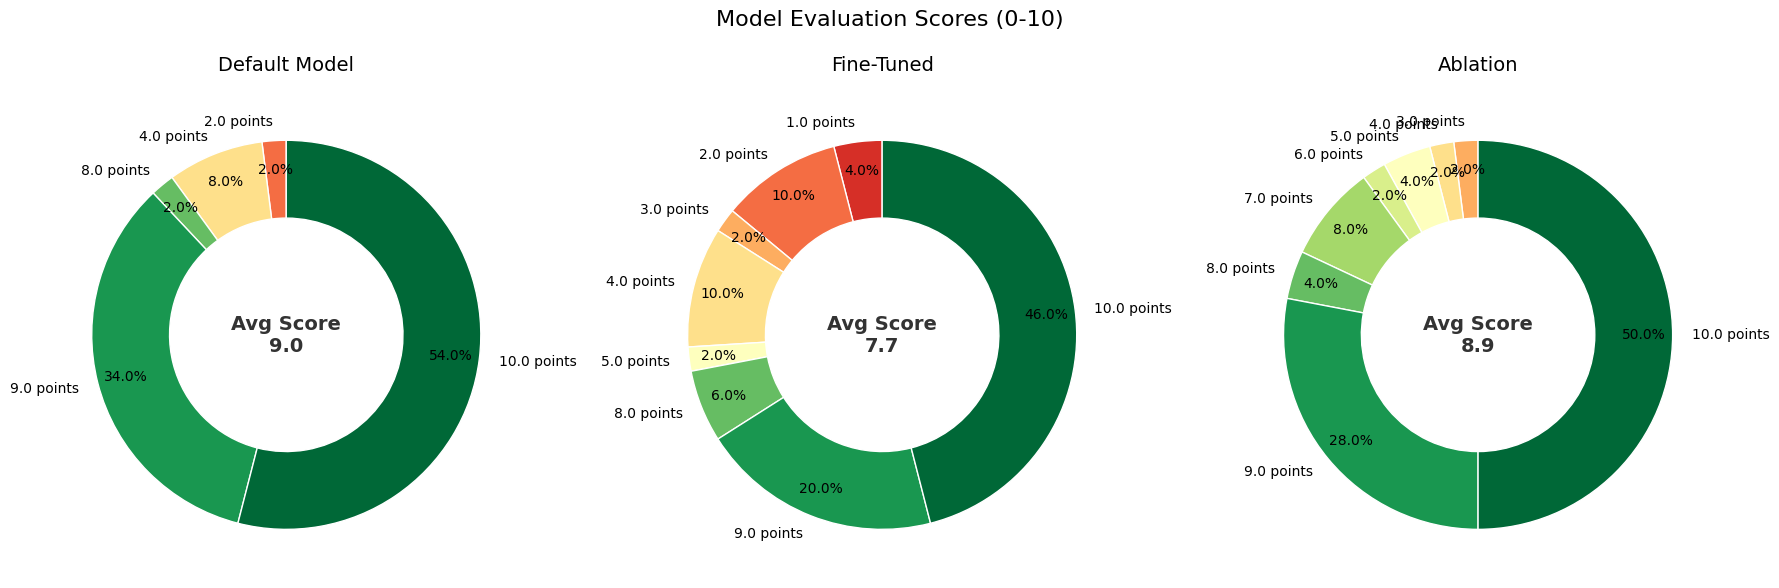

In [21]:
data_pack = [
    ("Default Model", scores_default, avg_dft),
    ("Fine-Tuned",    scores_ft,      avg_ft),
    ("Ablation",      scores_abl,     avg_abl),
]

cmap = plt.get_cmap('RdYlGn')

def get_color(score):
    return cmap(score / 10.0)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (title, data_list, avg_val) in zip(axes, data_pack):
    counts = Counter(data_list)

    sorted_scores = sorted(counts.keys())
    sizes = [counts[s] for s in sorted_scores]

    chart_colors = [get_color(s) for s in sorted_scores]
    labels = [f"{s} points" for s in sorted_scores]

    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=chart_colors,
        pctdistance=0.85,
        wedgeprops=dict(width=0.4, edgecolor='w', linewidth=1)
    )

    ax.set_title(title, fontsize=14, pad=15)

    ax.text(0, 0,
            f"Avg Score\n{avg_val:.1f}",
            ha='center', va='center',
            fontsize=14, fontweight='bold', color='#333333')

plt.suptitle("Model Evaluation Scores (0-10)", fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

### Let's check the retry time of the three cases!

In [22]:
n_retry_default = [item[2] for item in ans_default]
avg_retry_default = (0.0+sum(n_retry_default)/len(n_retry_default))

n_retry_ft = [item[2] for item in ans_ft]
avg_retry_ft = (0.0+sum(n_retry_ft)/len(n_retry_ft))

n_retry_abl = [item[2] for item in ans_abl]
avg_retry_abl = (0.0+sum(n_retry_abl)/len(n_retry_abl))

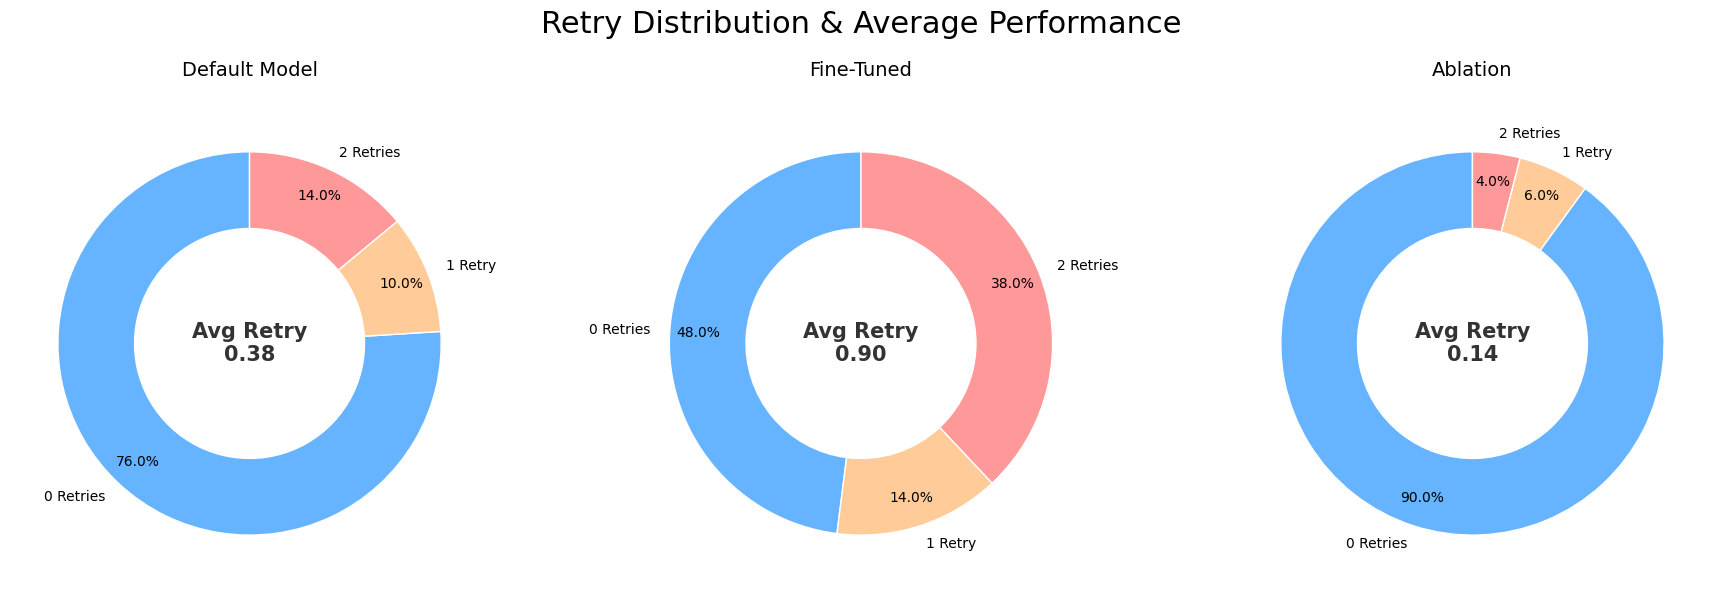

In [23]:
data_pack = [
    ("Default Model", n_retry_default, avg_retry_default),
    ("Fine-Tuned",    n_retry_ft,      avg_retry_ft),
    ("Ablation",      n_retry_abl,     avg_retry_abl),
]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

colors_map = {
    0: '#66b3ff',
    1: '#ffcc99',
    2: '#ff9999'
}
labels_map = ["0 Retries", "1 Retry", "2 Retries"]

for ax, (title, data_list, avg_val) in zip(axes, data_pack):
    counts = Counter(data_list)
    sizes = [counts.get(k, 0) for k in [0, 1, 2]]

    chart_colors = [colors_map[k] for k in [0, 1, 2]]

    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels_map,
        autopct='%1.1f%%',
        startangle=90,
        colors=chart_colors,
        pctdistance=0.85,
        wedgeprops=dict(width=0.4, edgecolor='w')
    )

    ax.set_title(title, fontsize=14, pad=20)

    ax.text(0, 0,
            f"Avg Retry\n{avg_val:.2f}",
            ha='center', va='center',
            fontsize=15, fontweight='bold', color='#333333')

plt.suptitle("Retry Distribution & Average Performance", fontsize=22, y= 0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### To be more clear, let's compare the averages directly!

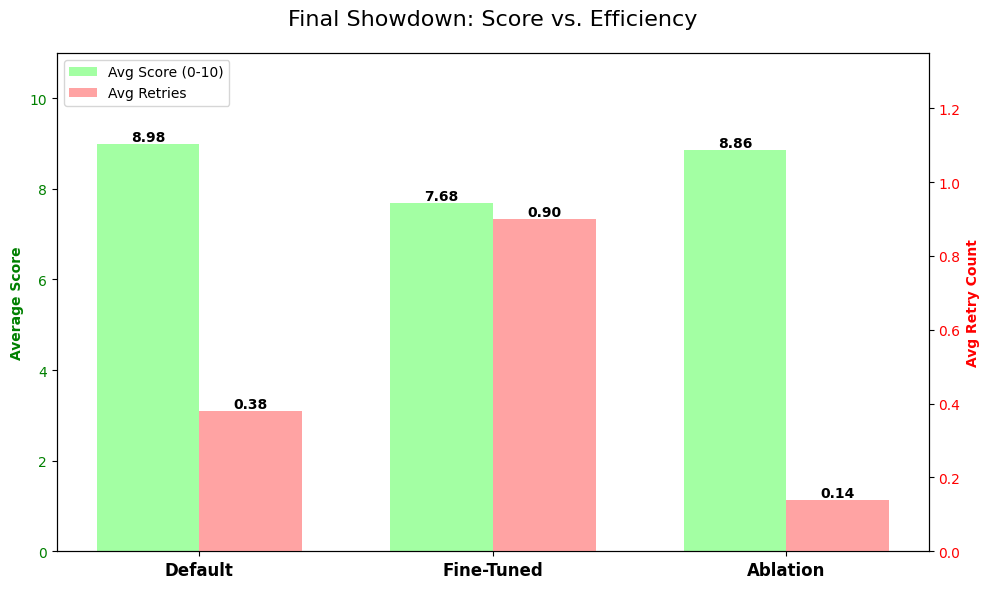

In [24]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Default', 'Fine-Tuned', 'Ablation']
avg_scores = [avg_dft, avg_ft, avg_abl]
avg_retries = [avg_retry_default, avg_retry_ft, avg_retry_abl]

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

bars1 = ax1.bar(x - width/2, avg_scores, width, label='Avg Score (0-10)', color='#99ff99', alpha=0.9)
ax1.set_ylabel('Average Score', color='green', fontweight='bold')
ax1.set_ylim(0, 11)
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, avg_retries, width, label='Avg Retries', color='#ff9999', alpha=0.9)
ax2.set_ylabel('Avg Retry Count', color='red', fontweight='bold')
ax2.set_ylim(0, max(avg_retries) * 1.5)
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=12, fontweight='bold')
ax1.set_title('Final Showdown: Score vs. Efficiency', fontsize=16, pad=20)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

def add_labels(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontweight='bold')

add_labels(bars1, ax1)
add_labels(bars2, ax2)

plt.tight_layout()
plt.show()